Dataset URL: https://datasetninja.com/dataset-of-annotated-food-crops-and-weed-images


# References:

- https://www.geeksforgeeks.org/machine-learning/random-forest-for-image-classification-using-opencv/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html - **stratification**
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

In [448]:
from pathlib import Path
import os
import cv2
import IPython
import matplotlib.pyplot as plt
from skimage.feature import hog
from random import randint
from PIL import Image

from skimage import data, exposure

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

import numpy as np

# Dataset exploration

In [129]:
ds_dir = Path("../data")
ds_dir.absolute()

PosixPath('/home/master/dev/demokritos/ml_assignments/autofarm_assignment/notebooks/../data')

In [130]:
# Check uniformity in images
import json
for each_f in ann_ds:
    with open(os.path.join(ds_dir, f"ann/{each_f}")) as f:
#         print(f"File: {os.path.join(ds_dir.absolute(), f'ann/{each_f}')}")
        d = str(json.load(f))
        if ("weed" in d) and ("crop" in d):
            print(f"Weed and Crop in => {each_f}")

In [263]:
imgs_files = os.listdir(ds_dir.absolute() / "img")
imgs_files_path = ds_dir / "img"

imgs_ds = []
for f in imgs_files:
    imgs_ds.append(os.path.join(ds_dir, f"img/{f}"))
imgs_ds.sort()
imgs_ds;

In [264]:
lbls_files = os.listdir(ds_dir.absolute() / "ann")
lbls_files_path = ds_dir / "ann"

lbls_ds = []
for f in lbls_files:
    lbls_ds.append(os.path.join(ds_dir, f"ann/{f}"))
lbls_ds.sort()
lbls_ds;

In [265]:
# Create dataset list[<img file>, <label>]
ds = []
for img, lbl in zip(imgs_ds, lbls_ds):
    with open(lbl) as f:
        l = ""
        d = str(json.load(f))
        if "weed" in d:
            l = "weed"
        elif "crop" in d:
            l = "crop"
        ds.append([img, l])
print(f"Total nof images: {len(ds)}")

Total nof images: 1176


In [260]:
# How many of each {weed, crop}
nof_weeds = len([row[1] for row in ds if row[1] == "weed"])
nof_crops = len([row[1] for row in ds if row[1] == "crop"])
print(f"Nof weed samples: {nof_weeds}")
print(f"Nof crop samples: {nof_crops}")

Nof weed samples: 1116
Nof crop samples: 60


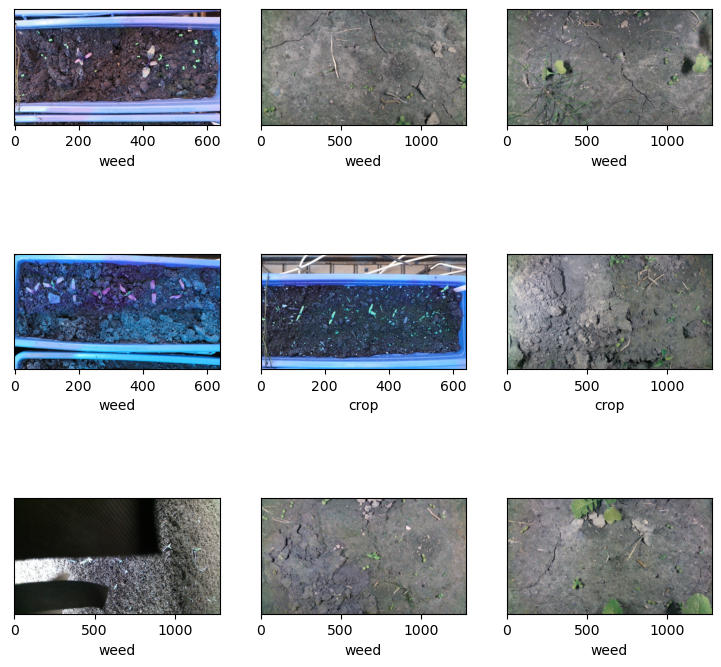

In [403]:
nof_cols, nof_rows = 3, 3
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(nof_cols*3, nof_rows*3))

for ax in axes.flatten():
    ax.get_yaxis().set_ticks([])
    ax.set_xlabel(xlabel=ds[record][1])
    record = randint(0, len(ds))
    ax.imshow(cv2.imread(ds[record][0]))

Determine min resolution from images.

In [272]:
min_width, min_height = 2000, 2000

for each_img in ds:
    img = Image.open(each_img[0])
    min_width = min(min_width, img.size[0])
    min_height = min(min_height, img.size[1])
    
print(f"Minimum resolution: {min_width, min_height}")

Minimum resolution: (360, 360)


### Notes:

**Dataset imbalance**: More weeds than crops.

**Minimum resolution**: Have to resize all images to match min resolution - uniformity.

---

Now that we have the list of image file, let's extract some features.

## Histogram of Oriented Gradients - HOG - Feature extraction

Used in shape recongnition.

For each image in the dataset:
1. Load image
2. Convert the image to grayscale
3. Resize the image to match min resolution
4. Extract HOG
5. Append to list with features

In [323]:
%%time

X_hog_features, y_hog_labels, X_hog_visual = [], [], []
for i in range(len(ds)):
    
    img = cv2.imread(ds[i][0])
    img_resized = cv2.resize(img, (min_width, min_height))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    if i%200 == 0:
        
        # Sample visual image
        hog_features, hog_visual = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True
        )
        X_hog_visual.append([ [i], [hog_visual] ])
        
    else:
        
        # Skip visual, just exctract features
        hog_features = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        
    # Collect features and labels
    X_hog_features.append(hog_features)
    y_hog_labels.append(ds[i][1])

CPU times: user 38.2 s, sys: 902 ms, total: 39.1 s
Wall time: 37.9 s


In [324]:
len(X_hog_features), len(y_hog_labels)

(1176, 1176)

In [465]:
len(X_hog_features[0])

69696

In [466]:
8*8*2*2*9

2304

In [353]:
X_hog_features[0]

array([0.28475655, 0.        , 0.02391007, ..., 0.18594874, 0.25146204,
       0.25146204])

In [333]:
len(X_hog_visual)

6

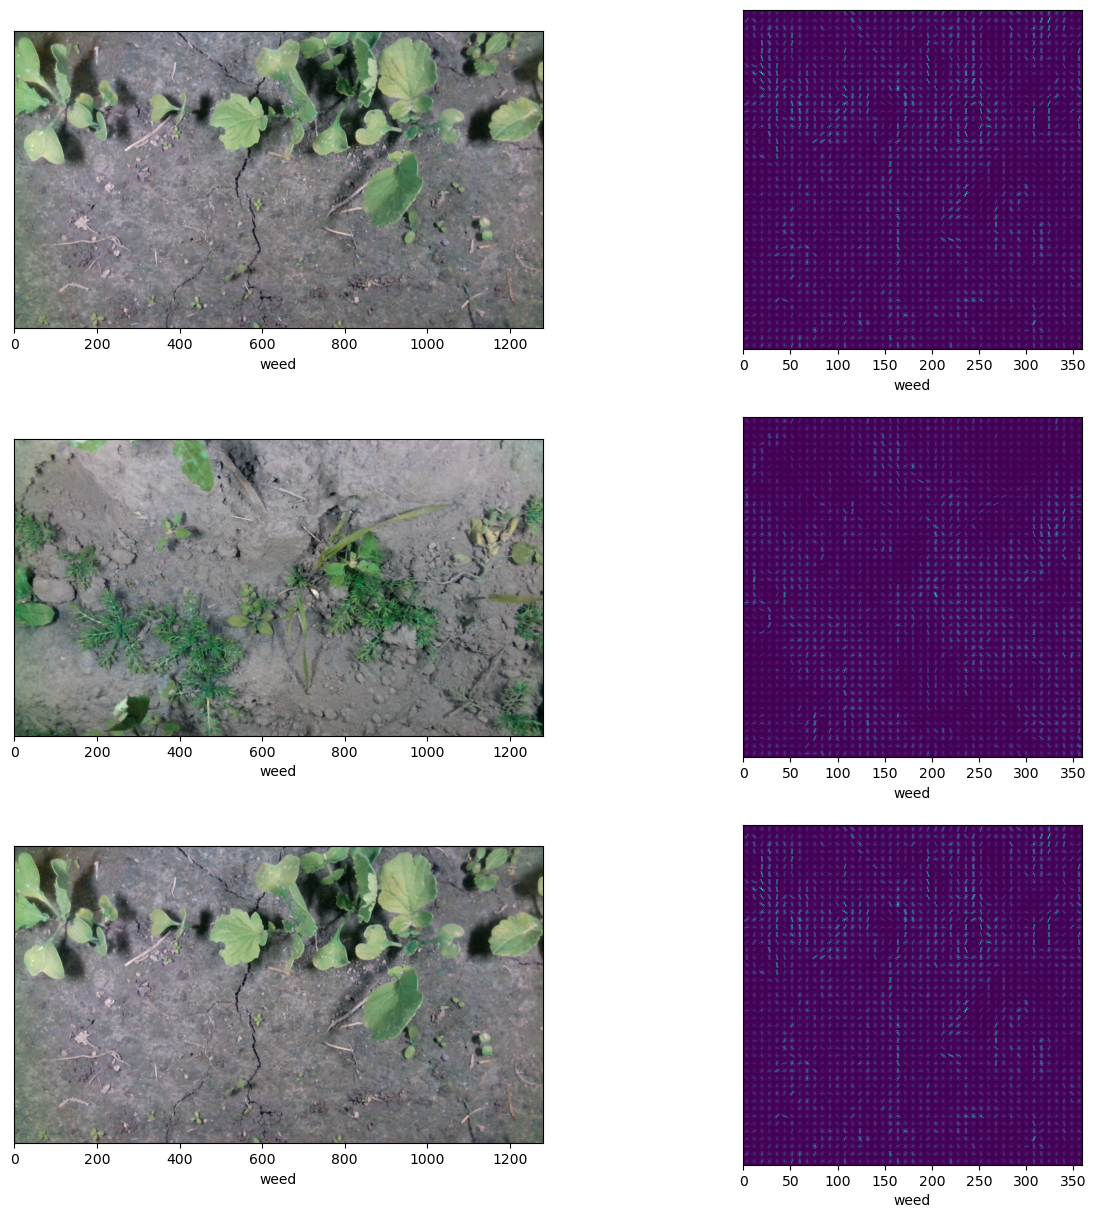

In [348]:
# How do images look like now?
nof_cols = 2
nof_rows = 3

fig, axes = plt.subplots(nrows=nof_rows, ncols=nof_cols, figsize=(15, 15))

for axs in axes:
    axs[0].get_yaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])
    
    rand_record_visual = randint(0, len(X_hog_visual))
    
    # Set label
    axs[0].set_xlabel(xlabel = ds[ X_hog_visual[ rand_record_visual ][0][0] ][1])
    axs[1].set_xlabel(xlabel = ds[ X_hog_visual[ rand_record_visual ][0][0] ][1])
    
    # Set images
    axs[0].imshow(cv2.imread(ds[X_hog_visual[rand_record_visual][0][0]][0]))
    axs[1].imshow(X_hog_visual[rand_record_visual][1][0])

HOG extractecd, does not look so useful to the human eye at least.

---

# Train random forest classifier

**Notes**

Because the dataset is imbalanced, let's train a classifier with 2 classes, weed and not weed instead of weed and crop.

In [363]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hog_features,
    y_hog_labels,
    train_size=0.8,
    stratify=y_hog_labels
)


In [390]:
print(
f"""Train samples: {len(X_train)}
Train labels: {len(y_train)}\n
Test samples: {len(X_test)}
Test labels: {len(y_test)}"""
)

Train samples: 940
Train labels: 940

Test samples: 236
Test labels: 236


In [395]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [407]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  For a comparison between tree-based ensemble models see the example
 |  :ref:`sp

Evaluation

In [409]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 95.34%


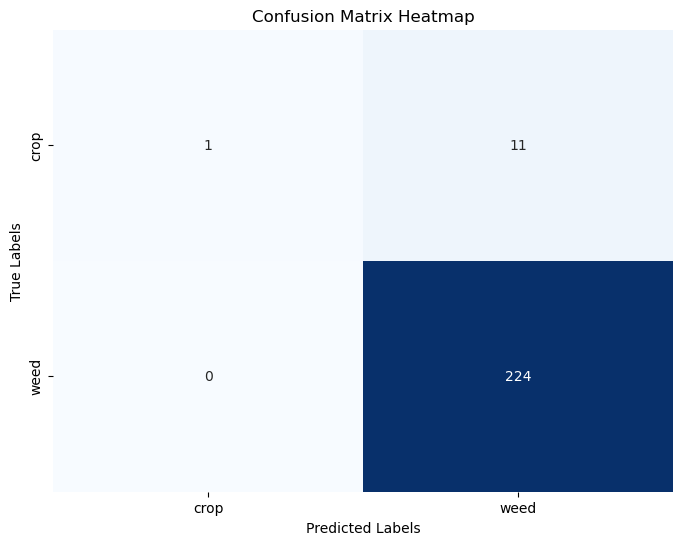

In [415]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["crop", "weed"], yticklabels=["crop", "weed"])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [426]:
print(f"Accuracy: {sum(conf_matrix.diagonal())/sum(conf_matrix.flatten())}")

Accuracy: 0.9533898305084746


In [461]:
recall_crop = conf_matrix[0][0]/conf_matrix[0].flatten().sum()
recall_weed = conf_matrix[1][1]/conf_matrix[1].flatten().sum()
print(f"Recall Crop: {recall_crop}")
print(f"Recall Weed: {recall_weed}")

Recall Crop: 0.08333333333333333
Recall Weed: 1.0


**High Recall** (closer to 1.0 or 100%): Indicates the model is very good at identifying all existing positive instances, resulting in very few false negatives (missed cases).

**Low Recall** (closer to 0): Indicates the model misses a large percentage of the actual positive instances, leading to many false negatives

Low recall on the crop shows that the model is bad at finding crops among weeds.

Surely this has to do with the fact that the dataset is highly imbalanced and the model does not learn to recognize crops very well.

In [462]:
precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
prevision_weed = conf_matrix[1][1]/conf_matrix[:,1].sum()
print(f"Precision Crop: {precision_crop}")
print(f"Precision Weed: {prevision_weed}")

Precision Crop: 1.0
Precision Weed: 0.9531914893617022


When the model sees a crop, it's highly certain that it's a crop. But, it does not dare to make that assumption many times. The models underfits for crop.

It makes more correct predictions for weed.

In [464]:
f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)
f1_score_weed = (2*prevision_weed*recall_weed)/(prevision_weed+recall_weed)
print(f"F1 score Crop: {f1_score_crop}")
print(f"F1 score Weed: {f1_score_weed}")

F1 score Crop: 0.15384615384615385
F1 score Weed: 0.9760348583877996


Low F1-score for the Crop class indicates that the model made a lot of False-Positive predictions - missclassified Crop as Weed.

High F1-score for the Weed class indicates the model made a lot of True-Positive predictions - correctly classified the Weed class.

- Test other classifiers.

1.Simplest-naive: balanced training dataset.

THrow away dominant class - with a more balanced ds.

2. Weighting on priors

3. Augmentation:

- SMOTE(features) only on train (on small sample)
- Measure macro-f1 score (different than just f1 score) - 2-3% improvement
- image augmentation - use ready


**Notes**

- Look for a library which can do augmentation automatically - don't reinvent the wheel.